# Wrangling OpenStreetMap Data with SQL
# Map Area
Munich, Germany

Munich, in German "München" is the capital of the German federal state of Bavaria. Bavaria is famous for its beer culture, pretzels, and the of course the Oktoberfest in Munich.

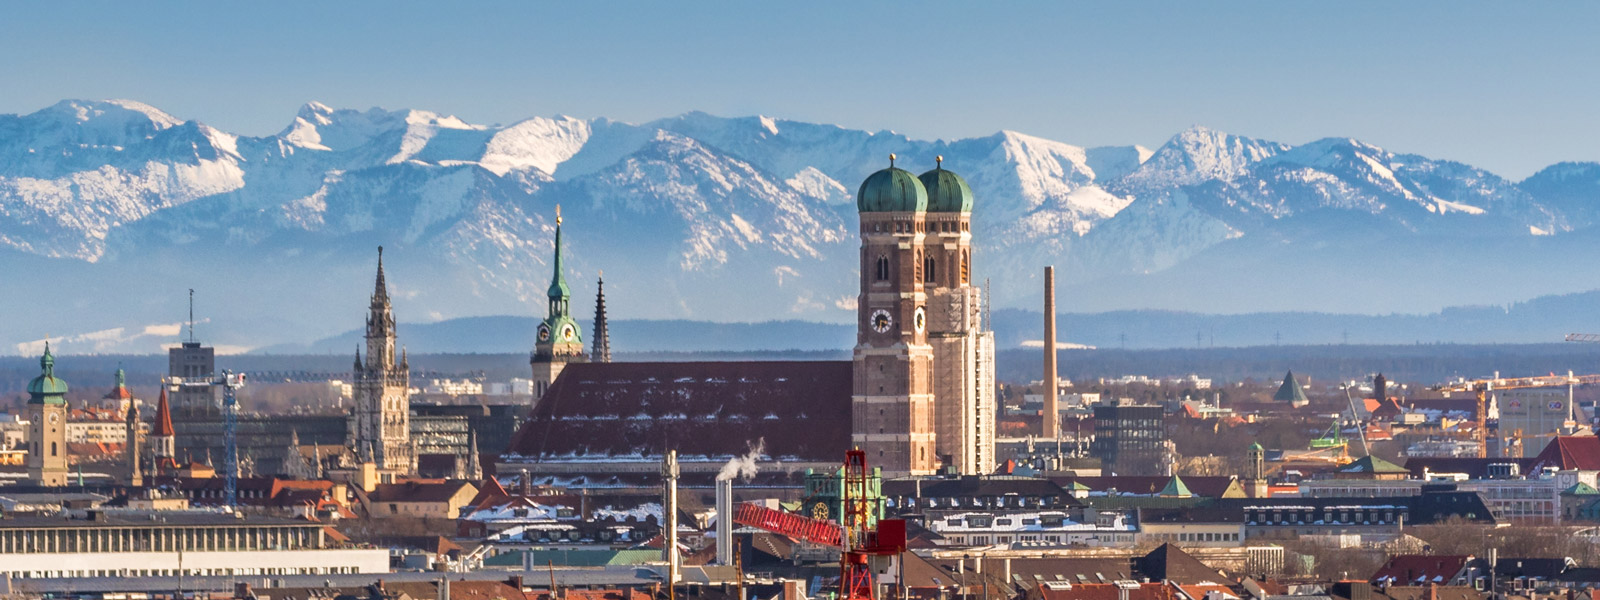

In [24]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(filename = "Munich_image.jpg")

OSM-data on munich: https://www.openstreetmap.org/export#map=11/48.1551/11.5418

Where I downloaded the actual file from: http://overpass-api.de/query_form.html

**For all python code on auditing and creating csv-files see main ipynb-file.**

In [7]:
import xml.etree.cElementTree as ET
import pprint
from pprint import pprint
from collections import defaultdict
import re
import os
import csv
import codecs
import cerberus
import sqlite3
import pandas as pd

In [6]:
OSM_FILE = "OSM_munich.osm"  # Replace this with your osm file
SAMPLE_FILE = "sample_file_munich.osm"

## Taking sample from OSM file
(Code: "Taking_sample.py")

First thing we create systematic sample elements from the original OSM-file. The original code is from Udacity - "Project Details". 

##### Check sizes of OSM- and Sample-Files:

Resource: http://stackoverflow.com/questions/2104080/how-to-check-file-size-in-python

In [8]:
#resource: http://stackoverflow.com/questions/2104080/how-to-check-file-size-in-python

def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0

def file_size(file_path):
    """
    this function will return the file size
    """
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)

#check size of sample file

OSM_size = file_size(OSM_FILE)
sample_size = file_size(SAMPLE_FILE)

print ('OSM File Size', OSM_size)
print ('Sample File Size', sample_size)

OSM File Size 313.6 MB
Sample File Size 51.7 MB


The actual original OSM file had a size of 1.21GB. Due to limitation of overall 500MB uploadable data in our project I had to size it down by taking only every 4th top level element resulting in a size of 313.6MB.
For the sample size there was a requirement of at least 50MB. Therefore taking every 6th top level element resulted in 51,7MB.

## Screening OSM-file

(Code: "Screening_OSM-file.py")

Due to size of OSM-file and therefore long runtime of my script I was only able to do screening on the sample file. Iterparsing the full OSM-file took way too long on my machine.

##### Unique users
We want to find out how many unique users have contributed to the map in this particular area. The function *process_map* returns a set of unique user IDs ("uid"). The original code is from Udacity - "Case Study - Exploring Users".

In [9]:
#getting unique users (!Ref. "Case Study - Exploring Users"!)

def get_user(element):
    uid = ''
    if element.tag == "node" or element.tag == "way" or element.tag == "relation":
        uid = element.get('uid')
    return uid


def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        if get_user(element):
            users.add(get_user(element))
            users.discard('')
        pass

    return users

users = process_map(SAMPLE_FILE)  # Using Sample file as input
print ('UNIQUE USERS: ', len(users))

UNIQUE USERS:  3294


##### Counting element tags
We use the iterative parsing to process the map file and find out not only what tags are there, but also how many, to get the feeling on how much of which data we can expect to have in the map. The original code is from Udacity - "Case Study - Iterative Parsing"

In [10]:
# Counting the element tags in the file (!Ref. Case Study - Iterative Parsing!)

def count_tags(filename):
    tags = {}
    for event,elem in ET.iterparse(filename, events=("start",)):
        if elem.tag in tags.keys():
            tags[elem.tag] += 1
        else:
            tags[elem.tag] = 1
    return tags    
    
tags = count_tags(SAMPLE_FILE)  # Using Sample file as input
pprint(tags)

{'member': 24282,
 'nd': 278994,
 'node': 210781,
 'osm': 1,
 'relation': 633,
 'tag': 194004,
 'way': 38068}


##### Element sub tags

Before we process the data and add it into our database, we check the
"k" value for each "<tag>" and see if there are any potential problems.

The original code is from Udacity - "Case study OSM - Tag Types"
    
There is 1 problematic character in the sample file!  

In [11]:
# Finding out formatting scheme of K attribute in tags (!Ref. "Case study OSM - Tag Types"!)

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

keys = defaultdict(int)

def key_count(keys, element):
    if element.tag == 'tag':
        keys[element.attrib['k']] += 1
    return keys

def key_type(element, key_categories):
    if element.tag == "tag":
        if lower.match(element.attrib['k']):
            key_categories["lower"] += 1
        elif lower_colon.search(element.attrib['k']):
            key_categories["lower_colon"] += 1
        elif problemchars.search(element.attrib['k']):
            key_categories["problemchars"] += 1
        else:
            key_categories["other"] += 1
        pass
        
    return key_categories

def process_key_map(filename):
    key_categories = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        key_categories = key_type(element, key_categories)
        key_count(keys, element)

    return key_categories

key_categories = process_key_map(SAMPLE_FILE)
pprint(key_categories)

{'lower': 108611, 'lower_colon': 83824, 'other': 1568, 'problemchars': 1}


## Audit data

(Code: "Audit_data.py")

#### Audit phone numbers

Phone numbers are matched against a standard pattern. The standard international phone number format is <country code> <3 digit area code> <6-8 digit number>. For Germany the country code is +49.
(Ref.: https://wiki.openstreetmap.org/wiki/DE:Key:phone)

In [12]:
phone_re = re.compile(r'^\+49\s\d{3}\s\d{6,8}$')

#### Audit post codes

Post codes are matched against a 5-digit standard and the official list of post codes published by the city of Munich. 
(Ref.: https://www.muenchen.de/int/en/living/postal-codes.html)

In [10]:
postcode_re = re.compile(r'^\d{5}$')

#### Audit street types

Street names are checked against a regular expression containing common street types

In [11]:
pattern = r'''
^(Am\b|Auf\sdem\b|Auf\sder\b|Im\b|In\sder\b|An\b|Zum\b|Zur\b)|
(straße|\bStraße|-Straße|\bWeg|weg|-Weg|platz|-Platz|\bPlatz|gasse|
\bRing|ring|\bHof|hof|\bAllee|-Allee|allee|wall|\bWall|markt|gürtel|feld)$'''

## Problems Encountered in the Map

Phone numbers: There are several wrong formats like e.g. '+49 (0) 89/35063630'. This phone number contains "(0)" which is not intended and a slash which is also wrong. Correct would be '+49 89 35063630'
Many others also contain dashes, e.g.'+49 (0)89-898676-0'

Postal codes: There are quite many post code entries (103) which according to "https://www.muenchen.de/int/en/living/postal-codes.html" do not belong to the actual city of munich but surrounding cities.

Street names: No real problems were found in street names. Although there are several cases of 'straße', 'Straße' and '-Straße' this is not a case of inconsistency but represent the actual valid naming.

## Data Cleaning
(Code: "Audit_data.py")

In this step we try to fix the problematic data which we encountered in the map. For street names everything was fine.

#### Phone numbers:

We try to remove errors like a missing country code by checking against several regex's. See main ipynb-file.

#### Post codes:

Postcodes which did not match any of the postcode values associated with Munich were skipped, i.e., incorrect postcodes were not exported to the csv files and therefore not imported to the database. If the postcode did not match the regular expression r'^\d{5}$', it was skipped . If it matched the regular expression but it was not one of the postcodes associated with Munich, then the whole element associated with that postcode was skipped. These cleaning steps are performed in the shape_element function.

## Preparing for Database - SQL
(Code: "Prepare_for_database.py")

After auditing is complete the next step is to prepare the data to be inserted into a SQL database.
To do so we will transform the elements in the OSM XML file from document format to
tabular format, thus making it possible to write to .csv files.  These csv files can then easily be
imported to a SQL database as tables.

## Create SQL-database
(Code: "Prepare_for_database.py")

The csv-files that we just created shall now imported into an SQL-database.
At first for each csv.-file we create an SQL-table using a given schema.

#### Importing to database

Since the SQL-tables are still empty we need to fill them with the actual values

In [9]:
# Connect to the database
conn = sqlite3.connect('osm.db')

# Get a cursor object
cur = conn.cursor()

### Database overview 

File size of SQL-database and csv.-tables

In [18]:
print ('SQL-database', file_size('osm.db'))
print ('nodes.csv', file_size('nodes.csv'))
print ('ways.csv', file_size('ways.csv'))
print ('nodes_tags.csv', file_size('nodes_tags.csv'))
print ('ways_tags.csv', file_size('ways_tags.csv'))
print ('ways_nodes.csv', file_size('ways_nodes.csv'))

SQL-database 25.2 MB
nodes.csv 16.1 MB
ways.csv 1.9 MB
nodes_tags.csv 1.8 MB
ways_tags.csv 3.1 MB
ways_nodes.csv 5.7 MB


## SQL-queries

#### Statistical Exploration
#### Number of unique Users:

In [26]:
users = pd.read_sql('''
SELECT COUNT(*)
        FROM (SELECT uid FROM nodes UNION SELECT uid FROM ways);
''', conn)

users

,COUNT(*)
0,3218


#### Number of nodes

In [27]:
number_of_nodes = pd.read_sql('''
SELECT COUNT(id) FROM nodes;
''', conn)

number_of_nodes

,COUNT(id)
0,207990


#### Number of ways

In [28]:
number_of_ways = pd.read_sql('''
SELECT COUNT(id) FROM ways;
''', conn)

number_of_ways

,COUNT(id)
0,33928


#### Top10 users:

In [29]:
top10_users = pd.read_sql('''
SELECT a.user, COUNT(*) as num
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) a
GROUP BY a.user
ORDER BY num DESC
LIMIT 10;
''', conn)

top10_users

,user,num
0,ToniE,22316
1,BeKri,15834
2,Hans Loderer,9481
3,heilbron,7266
4,rolandg,6537
5,Luktopus,5991
6,Basstoelpel,5637
7,ocotillo,5476
8,Guenni,5024
9,miche101,4780


#### Top 10 amenities:

In [30]:
top10_amenities = pd.read_sql('''
SELECT value amenities, COUNT(*) as num
FROM nodes_tags
WHERE key='amenity'
GROUP BY value
ORDER BY num DESC
LIMIT 10;
''', conn)

top10_amenities

,amenities,num
0,bench,578
1,waste_basket,183
2,vending_machine,162
3,bicycle_parking,107
4,restaurant,92
5,parking_entrance,73
6,recycling,72
7,post_box,65
8,parking,59
9,hunting_stand,51


#### Top 10 Cafés:

In [31]:
top10_cafes = pd.read_sql('''
SELECT value Cafes, COUNT(*) AS Num 
FROM nodes_tags 
JOIN (SELECT DISTINCT id FROM nodes_tags WHERE value="cafe") nodes_ids
ON nodes_tags.id=nodes_ids.id
WHERE key="name" 
GROUP BY value 
ORDER BY COUNT(*) DESC  
LIMIT 10;
''', conn)

top10_cafes

,Cafes,Num
0,Cafeteria,2
1,benko,1
2,Wimmer,1
3,Tushita Teehaus,1
4,Tree's Smoothies & Soul Food,1
5,Stehcafe an der TU,1
6,Solino Caffé,1
7,Sip And Dip,1
8,Schnickschnack,1
9,Noah's Eiswelt,1


#### Beer gardens

How many "beer gardens" do we have in our dataset? Going to beer gardens is a must do when you visit Munich as tourist.

In [73]:
beergarden = pd.read_sql('''
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT * FROM nodes_tags WHERE value ='biergarten') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='amenity'
''', conn)

beergarden

,value,num
0,biergarten,5


In [23]:
beergarden = pd.read_sql('''
SELECT nodes_tags.id, nodes_tags.key, nodes_tags.value
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value ='biergarten') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key = 'amenity'
''', conn)

beergarden

,id,key,value
0,1310929669,amenity,biergarten
1,1335381155,amenity,biergarten
2,1493493815,amenity,biergarten
3,3736311251,amenity,biergarten
4,7213595203,amenity,biergarten


#### Puplic toilets:
It is very important that you be well informed about public toilets when you visit a city as Munich as a tourist. Expecially in Munich where beer tasting is a major part of the visit.

In [27]:
toilets = pd.read_sql('''
SELECT nodes_tags.key, nodes_tags.value, nodes_tags.type, nodes.lat, nodes.lon, nodes.timestamp
FROM nodes_tags
JOIN nodes
ON nodes_tags.id = nodes.id
WHERE value LIKE '%toilet%'
LIMIT 4;
''', conn)

toilets

,key,value,type,lat,lon,timestamp
0,amenity,toilets,regular,47.962409,11.315179,2017-03-16T06:03:34Z
1,amenity,toilets,regular,48.188053,11.232464,2020-02-16T16:39:05Z
2,amenity,toilets,regular,48.207472,11.360915,2013-10-29T09:47:18Z
3,amenity,toilets,regular,48.123473,11.759894,2013-04-07T16:41:44Z


#### Top 10 cuisines:

In [28]:
top10_cuisines = pd.read_sql('''
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='restaurant') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='cuisine'
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 10;
''', conn)

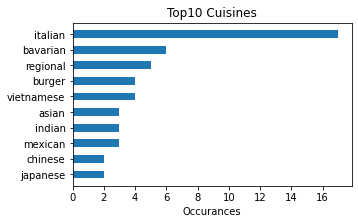

In [31]:
import matplotlib.pyplot as plt
top10_cuisines.sort_values('num', ascending = True, inplace = True)
plt.figure(figsize=(5,3)) 
plt.barh(top10_cuisines['value'], top10_cuisines['num'], height = 0.5);
plt.title("Top10 Cuisines");
plt.xlabel("Occurances");

#### Religions
How is the distribution of places of worship per religion?

In [34]:
religions = pd.read_sql('''
SELECT ways_tags.value, COUNT(*) as num
FROM ways_tags
    JOIN (SELECT DISTINCT(id) FROM ways_tags WHERE value='place_of_worship') a
    ON ways_tags.id=a.id
WHERE ways_tags.key='religion'
GROUP BY ways_tags.value
ORDER BY num DESC;
''', conn)

religions

,value,num
0,christian,28


### Verify the cleaning process

Process is elaborated in more depth in main ipynb-file.
#### Non-Munich city tags
Let's check if some city tags other than "München" made it through the cleaning process

In [35]:
city_count = pd.read_sql('''
SELECT tags.value, COUNT(*) as count 
FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) tags
WHERE tags.key = 'city'
GROUP BY tags.value
ORDER BY count DESC;
''', conn)

city_count

,value,count
0,München,5375
1,Pullach i. Isartal,75
2,Neuried,51
3,Planegg,15
4,Unterhaching,13
5,Vaterstetten,6
6,Haar,6
7,Karlsfeld,5
8,Freising,5
9,Schäftlarn,4


Unfortunately yes. In this case we are interested to know the corresponding postalcodes as a means to check if it is due to a wrong city tag or if also the postcodes do not belong to Munich.

In second step we query the list of Non-Munich city tags for every unique id. There are overall 218 Elements that have a Non-Munich city tag and therefore do not belong in the database.

In third step we want to join these lists in order to receive the adresses of the non-munich city tags

In [38]:
city_tags_not_munich_joined_with_postcode_tags = pd.read_sql('''
SELECT *
FROM (SELECT ptags.id, ptags.value postcode, ptags.key
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ptags
      WHERE ptags.key = 'postcode' OR ptags.key = 'postal_code') postcodes
JOIN (SELECT ctags.id, ctags.value city, ctags.key
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ctags
      WHERE ctags.key = 'city' and ctags.value NOT LIKE 'München%') cities
ON postcodes.id = cities.id
''', conn)

city_tags_not_munich_joined_with_postcode_tags

,id,postcode,key,id,city,key
0,1280387631,82049,postal_code,1280387631,Pullach i. Isartal,city


Oh no, why does this only return one result? 
The explanation for this is that all the element ids with non-munich city tags have no postcodes assigned. During cleaning in Python only the elements with postcodes not being in the expected postcode list were sorted out. But we did not consider the case that there might be elements that don't come with a postcode tag. That is why these elements were missed during cleaning.

But why do we have one result then?
This is because it has been forgotten in the cleaning that there are apparently some elements which have the key "postal_code" instead of "postcode". Since this inconsistency has not been considered this is the reason why this element is still in the database.

#### Solving the problems
1) The first issue, which is some missed city tags that do not belong to Munich we just solve by deleting all rows where the city keys are not 'München'

2) Second issue where there is one row not belonging to Munich with key 'postal_code. We delete the rows where city keys are not 'München' and where key is 'postal_code'. Hereby all rows of the element are thoroughly deleted in the database.

#### Continuing with investigation on postcodes for correct 'Munich' city tags

Do we also have some 'postal_code' tags in the elements correctly beloning to Munich? Let's query that:

In [42]:
city_tags_not_munich_joined_with_postcode_tags = pd.read_sql('''
SELECT *
FROM (SELECT ptags.id, ptags.value postcode, ptags.key
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ptags
      WHERE ptags.key = 'postcode' OR ptags.key = 'postal_code') postcodes
JOIN (SELECT ctags.id, ctags.value city, ctags.key
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ctags
      WHERE ctags.key = 'city' and ctags.value LIKE 'München%') cities
ON postcodes.id = cities.id
WHERE postcodes.key = 'postal_code'
''', conn)

city_tags_not_munich_joined_with_postcode_tags

,id,postcode,key,id,city,key
0,2450480057,80469,postal_code,2450480057,München,city
1,2450480082,80469,postal_code,2450480082,München,city


Yes, there are two result. So we can see that there are much fewer cases with 'postal_code' tags but they exist.

Do we encounter the same problem of missing postcode tags also for elements with correct 'Munich' city tags?
When we make a LEFT JOIN on the IDs of elements with city key 'Munich' where postcode is "Null" this should return all "None" entries in the postcode column.

There are 778 Null values. Which means elements that have a correct city tag but miss a postcode tag. 

What do we do about these too issues? Nothing. Although it is inconsistent data these are still valid entries.

#### Verify phone numbers

In [44]:
phone_numbers = pd.read_sql('''
SELECT tags.value
FROM (SELECT * FROM nodes_tags UNION 
      SELECT * FROM ways_tags) tags
WHERE tags.key = 'phone' and tags.value NOT LIKE '+49 ___ %';
''', conn)

phone_numbers

,value


No reslts. So everything seems to be clean here.

## Data Cleaning Process Findings

The overall data quality is rather good. After writing the data to csv files I used SQLight3 and the Pandas SQLreader to make queries directly in the notebook. The findings I made here were primarily due to mistakes in the cleaning process and not due to lack of data quality. Problems with the dataset quality where mainly already found during screening in python.

1. Validity:
- Quite many postcodes were invalid since they did not actually belong to munich and had to be sorted out. 
- There was only one problem character found during screening. So that is quite good.
2. Accuracy:
- One mayor mistake in the cleaning process came from not anticipating cases where elements contain a city key but do not provide a postcode key. This could be avoided if there was thoroughly filled data. In this case lacking accuracy, respectively completeness.
3. Completeness:
- The actual original OSM file had a size of 1.21GB. Due to limitation of overall 500MB uploadable data in our project I had to size it down by taking only every 4th top level element resulting in a size of 313.6MB. From this file was taken a sample file containing every 6th top level element with which the analysis is based upon. This means the sample size is only about 1/24 of the entire dataset. This is definitely far from complete.
4. Consistency:
- Further for postcode tags an inconsitency in the naming was found, in one table being called 'postcode' in the other 'postal_code'. This lead to some elements with Non-Munich post codes not being removed in the cleaning process.
5. Uniformity:
- Phone number formats where quite often not uniform. Many errors in the dataset had to be cleaned.

## Ideas for Improvement
- Data quality
It would facilitate things a lot if there was already satisfactory data quality available. No cleaning whatsoever. Sounds like I dream come true. But why should this be unrealistic to achieve? If any input by contributers would be automatically checked against a predefined schema and the inputs not fulfilling that schema be immediately rejected, then from my point of view inconsistent data would be avoided in the first place. But I suspect this is against the philosophy of open source applications. 
- Amount of available data
The more data there is available the more possible use cases will be generated. This attracts customers and raises attention and importance of the Open Street Map project. When people see the benefit and importance then more pressure is put on the project to further improve data quality and grow the project.

Possible means to achieve this:
- Creating an app which improves the ease of use attract more users. People could then create entries while on the go or sitting in a café. In an app one could easily provide a format in which peple can fill their entries which makes data much more consistent. Location coordinates could be easily transfered since the smartphone knows ones position anyway. Hence, no manual entering of coordinates, which is very prone to error. Further an app would make it open for everybody to contribute. So far, people may have the impression that one needs to be an IT-nerd to be able to contribute.

## Conclusion
The Open Street Map data of the city of Munich, Germany, was audited, in particular street types, postcodes and phone numbers. Problems were encountered and cleaned programmatically. Later, the data was converted from XML to CSV format and imported to an SQL database. Querying the database allowed to have a statistical overview of the dataset and also, to find new problems with the dataset and identify some wrong city tags which resulted from a mistake made earlier in the cleaning stage. The mistake come from not anticipating cases where elements containg a city key but do not provide a postcode key. 

Further for postcode tags an inconsitency in the naming was found, in one table being called 'postcode'in the other 'postal_code'. 


These two problems were solved within the SQL-database by deleting the respective rows. For the fist problem this is not the ideal way of solving the issue because there still remain other attributes of the respective elements. So either one should delete all rows with the respective IDs, but since this is quite a number of elements this is not easily done. Or one should refine the Python cleaning process such that these elements are not exported to the csv. tables in the first place. Although the dataset is in general quite valid and accurate, its quality regarding consistency can be improved. 

## Notes

For this project I used python3 and not python 2. Most of the code provided from Udacity is Python2 code. For me it was not clear that it would have been fine to just use python 2 for this project, which would have made things a lot easier. Hence, I had to translate several snippets from 2 to 3 where other could just use to provided code. Obviously this took me more time. I would have expected from Udacity to update the code in the lessons for Python3, at least to just state that using Python 2 is ok.